<a href="https://colab.research.google.com/github/Solrak97/tf-vgg16-flowerdata/blob/main/VGG_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transferencia de aprendizaje utilizando VGG16

In [4]:
%%capture
! pip install kaggle torchmetrics wandb
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! rm -rf flowers
! kaggle datasets download alxmamaev/flowers-recognition
! unzip flowers-recognition.zip
! rm -r flowers-recognition.zip
! rm -rf flowers/sample_data/

In [29]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import pickle
import sklearn.metrics as metrics
import seaborn as sns
import pandas as pd

from torchmetrics import F1Score, Recall, Precision, Accuracy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Carga del dataset

In [6]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

dataset = ImageFolder("flowers")
train, val = torch.utils.data.random_split(dataset, [4317 - 863, 863], generator=torch.Generator().manual_seed(42))

train.dataset.transform = transform_train
val.dataset.transform = transform

training_loader = torch.utils.data.DataLoader(train, batch_size=200, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val, batch_size = 200, shuffle=False)

In [7]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

## Modificación del modelo base VGG16

In [8]:
classes = ('Margarita', 'Dientes de león', 'Rosa', 'Girasol', 'Tulipan')

In [9]:
# Creación del modelo VGG16
model = models.vgg16(pretrained=True)

# Congelamiento del modelo base
for param in model.features.parameters():
  param.requires_grad = False

n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))

# Reemplzo de la capa de salida
model.classifier[6] = last_layer
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

## Entrenamiento del modelo

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [11]:
epochs = 10

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)


## Metricas

In [31]:
def confussion_matrix(y_true, y_pred, classes):
  y_true = y_true.cpu()
  _, y_pred = torch.max(y_pred.cpu(), 1)

  cf_matrix = metrics.confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix, index=[i for i in classes],
                         columns=[i for i in classes])

  plt.figure(figsize=(10, 7))
  sns.heatmap(df_cm, annot=True, fmt='g', cmap='YlOrBr')

  plt.show()

In [20]:
batched_labels = torch.tensor([]).to(device)
batched_predictions = torch.tensor([]).to(device)

with torch.no_grad():
  for val_inputs, val_labels in validation_loader:
    val_inputs = val_inputs.to(device)
    val_labels = val_labels.to(device)
    val_outputs = model(val_inputs)

    batched_labels = torch.cat((batched_labels, val_labels), dim=0)
    batched_predictions = torch.cat((batched_predictions, val_outputs), dim=0)

batched_labels = batched_labels.type(torch.int32)


              Model Info

Precision:        0.8717508912086487
Accuracy:         0.8736963868141174
Recall:           0.8724355101585388
F1 Core:          0.8736963868141174




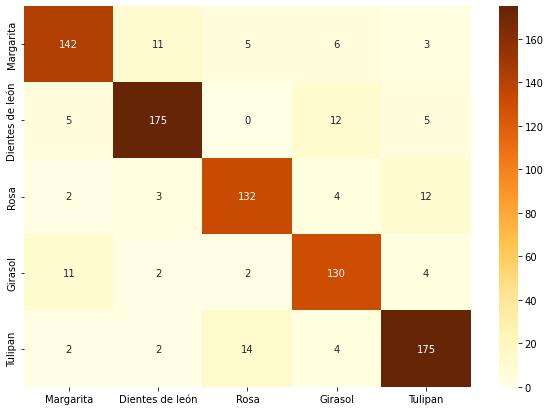

In [33]:
f1 = F1Score(num_classes=5).to(device)
recall = Recall(average='macro', num_classes=5).to(device)
precision = Precision(average='macro', num_classes=5).to(device)
accuracy = Accuracy().to(device)


print(f'''
              Model Info

Precision:        {precision(batched_predictions, batched_labels)}
Accuracy:         {accuracy(batched_predictions, batched_labels)}
Recall:           {recall(batched_predictions, batched_labels)}
F1 Core:          {f1(batched_predictions, batched_labels)}

''')

confussion_matrix(batched_labels, batched_predictions, classes)

## Guardar modelo

In [13]:
def save_checkpoint(model, path):
    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    
    # Check to see if model was parallelized
    if torch.cuda.is_available():
      if torch.cuda.device_count() > 1:
        checkpoint['classifier'] = model.module.classifier
        checkpoint['state_dict'] = model.module.state_dict()

    else:
       checkpoint['classifier'] = model.classifier
       checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

## Cargar modelo

In [14]:
def load_checkpoint(path, device):

    # Load in checkpoint
    checkpoint = torch.load(path)

    
    model = models.vgg16(pretrained=True)
    # Make sure to set parameters as not trainable
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = checkpoint['classifier']


    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to device
    model = model.to(device)

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [15]:
save_checkpoint(model, 'classifier.trch')
load_checkpoint('classifier.trch', device)

AttributeError: ignored